<a href="https://colab.research.google.com/github/marcusborela/Aprendizado-Profundo-Unicamp/blob/main/main/ex05/Marcus_Vinicius_Borela_de_Castro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
nome = 'Marcus Vinícius Borela de CAstro'

print(f'Meu nome é {nome}')

Meu nome é Marcus Vinícius Borela de CAstro


Este exercicío consiste em treinar no MNIST um modelo de duas camadas, sendo a primeira uma camada convolucional e a segunda uma camada linear de classificação.

Não podemos usar as funções torch.nn.Conv{1,2,3}d

# Inicializações

## Importação das bibliotecas

In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

In [45]:
import time

## Fixando as seeds

In [46]:
def inicializa_seed(num_semente:int=123):
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [47]:
inicializa_seed(123)

## Define pesos iniciais

In [48]:
in_channels = 1
out_channels = 2
kernel_size = 5
stride = 3

# Input image size
height_in = 28  
width_in = 28

# Image size after the first convolutional layer.
height_out = (height_in - kernel_size - 1) // stride + 1
width_out = (width_in - kernel_size - 1) // stride + 1

initial_conv_weight = torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01)
initial_conv_bias = torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01)

initial_classification_weight = torch.FloatTensor(10, out_channels * height_out * width_out).uniform_(-0.01, 0.01)
initial_classification_bias = torch.FloatTensor(10,).uniform_(-0.01, 0.01)

In [49]:
print(f" height_out {height_out}, width_out {width_out}")

 height_out 8, width_out 8


# Dataset e dataloader

### Definição do tamanho do minibatch

In [50]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [51]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [52]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [53]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [54]:
print('Número de minibatches de trenamento:', len(loader_train))


Número de minibatches de trenamento: 20


In [55]:
x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))


Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [56]:
x_train.shape, y_train.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

In [57]:
x_train[0, 0, 0, ] # 1a linha da 1a amostra

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [58]:
x_train[0, 0,] # 28 linhas da 1a amostra

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [59]:
x_train.shape[1] # canais

1

# Implementando Conv2d com for na imagem de saída

In [60]:
inicializa_seed(123)

In [61]:
# torch.cat((saida[0,0,0], torch.tensor([[12]])), dim=-1)

In [62]:
# saida

In [63]:
class MyConv2dForSaida(torch.nn.Module):
  """
  Versão com for sobre as dimensões do filtro de saída
  """

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, verbose:bool = False):
    super(MyConv2dForSaida, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size  # The same for height and width.
    self.stride = stride  # The same for height and width.
    self.weight = torch.nn.Parameter(torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01))
    self.bias = torch.nn.Parameter(torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01))
    self.verbose = verbose
    if self.verbose:
      print(f"Inicializado MyConv2dForSaida")
      print(f"in_channels: {self.in_channels} ")
      print(f"out_channels: {self.out_channels} ")
      print(f"kernel_size: {self.kernel_size} ")
      print(f"stride: {self.stride} ")
      print(f"weight.shape: {self.weight.shape} ")
      print(f"weight: {self.weight} ")
      print(f"bias.shape: {self.bias.shape} ")
      print(f"bias: {self.bias} ")

  def forward(self, x):
    assert x.dim() == 4, f'x must have 4 dimensions, not {x.shape}'
    assert x.shape[1] == 1, f'x must have only 1 channel, not {x.shape[1]}' # Num_canais sempre 1 (mnist, preto/branco)

    # print(f"kernel.shape: {self.weight.shape}, kernel: {self.weight}")
    # Escreva seu código aqui.
    # versão com for nas dimensões de X
    num_amostras = x.shape[0]
    num_linhas_entrada = x.shape[2]
    num_colunas_entrada = x.shape[3]
    num_linhas_saida = (num_linhas_entrada - self.kernel_size) // self.stride + 1
    num_colunas_saida = (num_colunas_entrada - self.kernel_size) // self.stride + 1
    saida = torch.zeros((num_amostras,self.out_channels,num_linhas_saida,num_colunas_saida), dtype=torch.float, requires_grad=False)        
    if self.verbose:
      print(f" num_amostras: {num_amostras}, self.out_channels: {self.out_channels}, num_linhas_entrada: {num_linhas_entrada}, num_colunas_entrada: {num_colunas_entrada}, num_linhas_saida: {num_linhas_saida}, num_colunas_saida: {num_colunas_saida}")
      print(f"saida.shape: {saida.shape}")
    for ndx_amostra in range(num_amostras):
      if self.verbose:
        print(f"\nndx_amostra: {ndx_amostra}")
      # for ndx_out_channels in range(self.out_channels):
      #   print(f"\nndx_out_channels: {ndx_out_channels}")
      for ndx_in_channels in range(self.in_channels):
        if self.verbose:
          print(f"\nndx_in_channels: {ndx_in_channels}")
        ndx_linhas_entrada = 0
        for ndx_linhas_saida in range(num_linhas_saida):
          ndx_colunas_entrada = 0
          for ndx_colunas_saida in range(num_colunas_saida):
            produto = torch.mul(x[ndx_amostra, ndx_in_channels, ndx_linhas_entrada:ndx_linhas_entrada+self.kernel_size, ndx_colunas_entrada:ndx_colunas_entrada+self.kernel_size], self.weight)
            soma = torch.sum(produto, dim=(2,3), keepdim=True )
            valor_soma = soma.squeeze()
            if self.verbose:
              print(f"\nndx_linhas_saida, ndx_colunas_saida: {ndx_linhas_saida}, {ndx_colunas_saida}")
              print(f" alvo do kernel em x: x[{ndx_amostra},{ndx_in_channels},{ndx_linhas_entrada}:{ndx_linhas_entrada+self.kernel_size}, {ndx_colunas_entrada}:{ndx_colunas_entrada+self.kernel_size}]")
              print(f" \n {x[ndx_amostra, ndx_in_channels, ndx_linhas_entrada:ndx_linhas_entrada+self.kernel_size, ndx_colunas_entrada:ndx_colunas_entrada+self.kernel_size]}")
              print(f" produto: {produto}")
              print(f" soma: {soma}")
              print(f" valor_soma: {valor_soma}")
            # saida = torch.cat((saida, soma))
            if self.out_channels > 1:  # soma é um com dimensões, como em torch.tensor([[[[ 46.]], [[134.]]]])
              for ndx_out_channels in range(self.out_channels):
                saida[ndx_amostra, ndx_out_channels, ndx_linhas_saida, ndx_colunas_saida] += valor_soma[ndx_out_channels]
                if self.verbose:
                  print(f" somado na saída em [{ndx_amostra}, {ndx_out_channels}, {ndx_linhas_saida}, {ndx_colunas_saida}] = {saida[ndx_amostra, ndx_out_channels, ndx_linhas_saida, ndx_colunas_saida]}")
            else: # soma é um tensor escalar, como em tensor(34.)
                saida[ndx_amostra, 0, ndx_linhas_saida, ndx_colunas_saida] += valor_soma
                if self.verbose:
                  print(f" somado na saída em [{ndx_amostra}, 0, {ndx_linhas_saida}, {ndx_colunas_saida}] = {saida[ndx_amostra, 0, ndx_linhas_saida, ndx_colunas_saida]}")
            ndx_colunas_entrada += self.stride
          ndx_linhas_entrada += self.stride
    if self.verbose:
      print(f" saida: {saida}")
    # somando bias
    for ndx_amostra in range(num_amostras):
      if self.verbose:
        print(f"\nndx_amostra: {ndx_amostra}")
      for ndx_out_channels in range(self.out_channels):
        saida[ndx_amostra, ndx_out_channels] += self.bias[ndx_out_channels]
    if self.verbose:
      print(f" saida apos somar bias: {saida}")
    # versão com for no kernel

    return saida

## Compare se sua implementação está igual à do pytorch usando um exemplo simples

In [64]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 2
stride_dummy = 1
x = torch.arange(30).float().reshape(1, 1, 5, 6)

In [65]:
print(x)

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.]]]])


In [66]:
x[0,0]

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 16., 17.],
        [18., 19., 20., 21., 22., 23.],
        [24., 25., 26., 27., 28., 29.]])

In [67]:

conv_layer = MyConv2dForSaida( in_channels=in_channels_dummy,out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, verbose=True)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(in_channels_dummy, out_channels_dummy, kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()

conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy

out = conv_layer(x)


Inicializado MyConv2dForSaida
in_channels: 1 
out_channels: 1 
kernel_size: 2 
stride: 1 
weight.shape: torch.Size([1, 1, 2, 2]) 
weight: Parameter containing:
tensor([[[[-0.0041,  0.0003],
          [-0.0050,  0.0038]]]], requires_grad=True) 
bias.shape: torch.Size([1]) 
bias: Parameter containing:
tensor([-0.0085], requires_grad=True) 
 num_amostras: 1, self.out_channels: 1, num_linhas_entrada: 5, num_colunas_entrada: 6, num_linhas_saida: 4, num_colunas_saida: 5
saida.shape: torch.Size([1, 1, 4, 5])

ndx_amostra: 0

ndx_in_channels: 0

ndx_linhas_saida, ndx_colunas_saida: 0, 0
 alvo do kernel em x: x[0,0,0:2, 0:2]
 
 tensor([[0., 1.],
        [6., 7.]])
 produto: tensor([[[[ 0.,  1.],
          [12., 21.]]]], grad_fn=<MulBackward0>)
 soma: tensor([[[[34.]]]], grad_fn=<SumBackward1>)
 valor_soma: 34.0
 somado na saída em [0, 0, 0, 0] = 34.0

ndx_linhas_saida, ndx_colunas_saida: 0, 1
 alvo do kernel em x: x[0,0,0:2, 1:3]
 
 tensor([[1., 2.],
        [7., 8.]])
 produto: tensor([[[[ 0.,

In [68]:
pytorch_conv_layer = torch.nn.Conv2d(out_channels=out_channels_dummy, in_channels=in_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, padding=0)
pytorch_conv_layer.load_state_dict(dict(weight=initial_weights_dummy, bias=initial_bias_dummy))
target_out = pytorch_conv_layer(x)

In [69]:
target_out.shape

torch.Size([1, 1, 4, 5])

In [70]:
assert torch.allclose(out, target_out, atol=1e-6)

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [71]:
x = torch.rand(2, in_channels, height_in, width_in)
print(f"x.shape: {x.shape}, x:{x}")

x.shape: torch.Size([2, 1, 28, 28]), x:tensor([[[[0.3153, 0.6871, 0.0756,  ..., 0.4340, 0.0772, 0.3565],
          [0.1479, 0.5331, 0.4066,  ..., 0.1634, 0.3009, 0.5201],
          [0.3834, 0.4451, 0.0126,  ..., 0.8858, 0.6568, 0.8459],
          ...,
          [0.0697, 0.6010, 0.1875,  ..., 0.1904, 0.0051, 0.0117],
          [0.6601, 0.6034, 0.5058,  ..., 0.1765, 0.4007, 0.9541],
          [0.8567, 0.4604, 0.2238,  ..., 0.0509, 0.9271, 0.2894]]],


        [[[0.8272, 0.9483, 0.8171,  ..., 0.5849, 0.4149, 0.2594],
          [0.1849, 0.2540, 0.4626,  ..., 0.1202, 0.6813, 0.3728],
          [0.8571, 0.0257, 0.7619,  ..., 0.0264, 0.0534, 0.0903],
          ...,
          [0.4493, 0.0843, 0.3308,  ..., 0.9408, 0.3042, 0.3526],
          [0.9909, 0.5564, 0.9295,  ..., 0.0156, 0.8797, 0.2511],
          [0.0361, 0.4623, 0.8646,  ..., 0.4430, 0.6219, 0.1061]]]])


In [72]:
conv_layer = MyConv2dForSaida(out_channels=out_channels, in_channels=in_channels, kernel_size=kernel_size, stride=stride, verbose=True)
conv_layer.weight.data = initial_conv_weight
conv_layer.bias.data = initial_conv_bias
print(f"conv_layer.weight.data.shape: {conv_layer.weight.data.shape}, conv_layer.bias.data.shape: {conv_layer.bias.data.shape}")
print(f"conv_layer.weight.data: {conv_layer.weight.data}, conv_layer.bias.data: {conv_layer.bias.data}")

Inicializado MyConv2dForSaida
in_channels: 1 
out_channels: 2 
kernel_size: 5 
stride: 3 
weight.shape: torch.Size([2, 1, 5, 5]) 
weight: Parameter containing:
tensor([[[[ 6.6078e-06, -9.2485e-03, -9.2362e-03,  1.8061e-04,  1.3908e-03],
          [ 1.8874e-03, -3.6917e-03, -1.0977e-03, -1.1083e-03, -3.3335e-04],
          [-6.4626e-03,  2.1828e-03,  3.0981e-03,  2.8529e-04, -8.1157e-04],
          [ 4.8421e-03,  6.7688e-03, -1.2534e-04, -7.5895e-03, -6.9633e-03],
          [-1.9524e-04, -9.1405e-03, -7.5606e-03, -2.4248e-03, -3.9989e-03]]],


        [[[-1.2834e-03,  2.4163e-03,  6.8450e-03,  9.9526e-03, -3.9993e-03],
          [-9.7703e-03,  6.6395e-03,  8.7120e-03,  9.5413e-03,  2.2681e-03],
          [ 6.3718e-03,  2.3667e-05, -7.0870e-03, -8.0465e-03, -5.9984e-03],
          [ 1.5156e-03, -2.5329e-03,  2.5571e-03,  3.5150e-03, -6.3376e-03],
          [ 7.9751e-04,  9.6898e-03,  6.5876e-03, -1.1136e-03, -2.0899e-03]]]],
       requires_grad=True) 
bias.shape: torch.Size([2]) 
bias: 

In [73]:
out = conv_layer(x)

 num_amostras: 2, self.out_channels: 2, num_linhas_entrada: 28, num_colunas_entrada: 28, num_linhas_saida: 8, num_colunas_saida: 8
saida.shape: torch.Size([2, 2, 8, 8])

ndx_amostra: 0

ndx_in_channels: 0

ndx_linhas_saida, ndx_colunas_saida: 0, 0
 alvo do kernel em x: x[0,0,0:5, 0:5]
 
 tensor([[0.3153, 0.6871, 0.0756, 0.1966, 0.3164],
        [0.1479, 0.5331, 0.4066, 0.2318, 0.4545],
        [0.3834, 0.4451, 0.0126, 0.7341, 0.9389],
        [0.3033, 0.6060, 0.9882, 0.8363, 0.9010],
        [0.9998, 0.2855, 0.9753, 0.2518, 0.7204]])
 produto: tensor([[[[-1.2855e-03,  2.2760e-04, -3.7565e-04,  7.4155e-04, -2.6960e-03],
          [ 1.0839e-03, -3.8744e-03, -3.2330e-03, -1.4648e-03,  2.0586e-03],
          [-1.4166e-03,  1.6655e-03, -1.0656e-04, -4.4542e-03, -3.4473e-03],
          [-5.9605e-04, -4.6229e-03,  6.4706e-03, -1.9723e-03,  2.8921e-03],
          [ 7.0697e-03,  5.3193e-04,  2.6670e-03,  2.4301e-03, -3.2491e-03]]],


        [[[ 9.9857e-04, -3.0570e-03,  5.4053e-04,  1.5705e-03

In [74]:
# Usa os mesmos pesos para minha implementação e a do pytorch
pytorch_conv_layer = torch.nn.Conv2d( in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)
pytorch_conv_layer.load_state_dict(dict(weight=initial_conv_weight, bias=initial_conv_bias))

target_out = pytorch_conv_layer(x)

In [75]:
target_out.shape

torch.Size([2, 2, 8, 8])

In [76]:
assert torch.allclose(out, target_out, atol=1e-6)

## Modelo

In [77]:
inicializa_seed(123)

In [78]:
class Net(torch.nn.Module):
    def __init__(self, height_in: int, width_in: int, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(Net, self).__init__()
        self.conv_layer = MyConv2dForSaida(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
   
        height_out = (height_in - kernel_size) // stride + 1
        width_out = (width_in - kernel_size) // stride + 1
        self.classification_layer = torch.nn.Linear(out_channels * height_out * width_out, 10)

    def forward(self, x):
        hidden = self.conv_layer(x)
        hidden = torch.nn.functional.relu(hidden)
        hidden = hidden.reshape(x.shape[0], -1)
        logits = self.classification_layer(hidden)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [79]:
n_epochs = 50
lr = 0.1

### Laço de treinamento

In [80]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)


In [81]:

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}  time: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')


Epoch: 0/49 Loss: 2.303267478942871  time: [2022-May-04 17:02:29]
Epoch: 1/49 Loss: 2.227700710296631  time: [2022-May-04 17:02:50]
Epoch: 2/49 Loss: 1.0923893451690674  time: [2022-May-04 17:03:10]
Epoch: 3/49 Loss: 0.5867354869842529  time: [2022-May-04 17:03:30]
Epoch: 4/49 Loss: 0.5144088864326477  time: [2022-May-04 17:03:50]
Epoch: 5/49 Loss: 0.45026642084121704  time: [2022-May-04 17:04:11]
Epoch: 6/49 Loss: 0.4075140655040741  time: [2022-May-04 17:04:30]
Epoch: 7/49 Loss: 0.3771387040615082  time: [2022-May-04 17:04:50]
Epoch: 8/49 Loss: 0.35344868898391724  time: [2022-May-04 17:05:10]
Epoch: 9/49 Loss: 0.3341451585292816  time: [2022-May-04 17:05:31]
Epoch: 10/49 Loss: 0.31811416149139404  time: [2022-May-04 17:05:51]
Epoch: 11/49 Loss: 0.30457884073257446  time: [2022-May-04 17:06:11]
Epoch: 12/49 Loss: 0.29283493757247925  time: [2022-May-04 17:06:31]
Epoch: 13/49 Loss: 0.2827607989311218  time: [2022-May-04 17:06:51]
Epoch: 14/49 Loss: 0.2738332748413086  time: [2022-May-

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

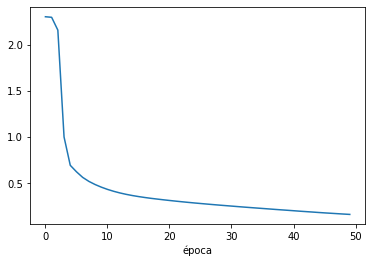

In [82]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [83]:
loss_epoch_end

[2.303267478942871,
 2.227700710296631,
 1.0923893451690674,
 0.5867354869842529,
 0.5144088864326477,
 0.45026642084121704,
 0.4075140655040741,
 0.3771387040615082,
 0.35344868898391724,
 0.3341451585292816,
 0.31811416149139404,
 0.30457884073257446,
 0.29283493757247925,
 0.2827607989311218,
 0.2738332748413086,
 0.26577436923980713,
 0.25832879543304443,
 0.25117501616477966,
 0.24439716339111328,
 0.23789949715137482,
 0.2316770702600479,
 0.22562646865844727,
 0.21984538435935974,
 0.2142913043498993,
 0.2089422643184662,
 0.2038729041814804,
 0.19903428852558136,
 0.1943996548652649,
 0.1899409145116806,
 0.18563994765281677,
 0.18147502839565277,
 0.17744921147823334,
 0.1734725832939148,
 0.16947472095489502,
 0.16547328233718872,
 0.16150493919849396,
 0.15746404230594635,
 0.15340439975261688,
 0.1492692232131958,
 0.14520636200904846,
 0.14123651385307312,
 0.13712680339813232,
 0.1331038475036621,
 0.12914663553237915,
 0.12515056133270264,
 0.12116765230894089,
 0.117317

In [84]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    2.303267478942871,
    2.227701187133789,
    1.0923893451690674,
    0.5867354869842529,
    0.5144089460372925,
    0.45026642084121704,
    0.4075140357017517,
    0.37713879346847534,
    0.3534485101699829,
    0.3341451585292816,
    0.3181140422821045,
    0.30457887053489685,
    0.29283496737480164,
    0.2827608287334442,
    0.2738332152366638,
    0.2657742500305176,
    0.2583288848400116,
    0.25117507576942444,
    0.24439716339111328,
    0.23789969086647034,
    0.23167723417282104,
    0.22562651336193085,
    0.21984536945819855,
    0.2142913043498993,
    0.20894232392311096,
    0.203872948884964,
    0.19903430342674255,
    0.19439971446990967,
    0.18994088470935822,
    0.18563991785049438,
    0.18147490918636322,
    0.17744913697242737,
    0.17347246408462524,
    0.16947467625141144,
    0.16547319293022156,
    0.16150487959384918,
    0.1574639081954956,
    0.1534043848514557,
    0.14926929771900177,
    0.1452063024044037,
    0.1412365883588791,
    0.13712672889232635,
    0.1331038922071457,
    0.1291467249393463,
    0.1251506358385086,
    0.12116757035255432,
    0.11731722950935364,
    0.11364627629518509,
    0.11001908034086227,
    0.10655981302261353])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

# Implementando Conv2d com for no Kernel

In [85]:
inicializa_seed(123)

In [86]:
class MyConv2dForKernel(torch.nn.Module):
  """
  Versão com for sobre o kernel 
  """
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, verbose:bool = False):
    super(MyConv2dForKernel, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size  # The same for height and width.
    self.stride = stride  # The same for height and width.
    self.weight = torch.nn.Parameter(torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01))
    self.bias = torch.nn.Parameter(torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01))
    self.verbose = verbose
    if self.verbose:
      print(f"Inicializado MyConv2dForKernel")
      print(f"in_channels: {self.in_channels} ")
      print(f"out_channels: {self.out_channels} ")
      print(f"kernel_size: {self.kernel_size} ")
      print(f"stride: {self.stride} ")
      print(f"weight.shape: {self.weight.shape} ")
      print(f"weight: {self.weight} ")
      print(f"bias.shape: {self.bias.shape} ")
      print(f"bias: {self.bias} ")

  def forward(self, x):
    assert x.dim() == 4, f'x must have 4 dimensions, not {x.shape}'
    assert x.shape[1] == 1, f'x must have only 1 channel, not {x.shape[1]}' # Num_canais sempre 1 (mnist, preto/branco)

    # print(f"kernel.shape: {self.weight.shape}, kernel: {self.weight}")
    # Escreva seu código aqui.
    # versão com for nas dimensões de X
    num_amostras = x.shape[0]
    num_linhas_entrada = x.shape[2]
    num_colunas_entrada = x.shape[3]
    num_linhas_saida = (num_linhas_entrada - self.kernel_size) // self.stride + 1
    num_colunas_saida = (num_colunas_entrada - self.kernel_size) // self.stride + 1
    saida = torch.zeros((num_amostras,self.out_channels,num_linhas_saida,num_colunas_saida), dtype=torch.float, requires_grad=False)        
    if self.verbose:
      print(f" num_amostras: {num_amostras}, self.out_channels: {self.out_channels}, num_linhas_entrada: {num_linhas_entrada}, num_colunas_entrada: {num_colunas_entrada}, num_linhas_saida: {num_linhas_saida}, num_colunas_saida: {num_colunas_saida}")
      print(f"saida.shape: {saida.shape}")
    for ndx_amostra in range(num_amostras):
      if self.verbose:
        print(f"\nndx_amostra: {ndx_amostra}")

      for ndx_linhas_kernel in range(self.kernel_size):
        for ndx_colunas_kernel in range(self.kernel_size):
          if self.verbose:
            print(f"\nndx_linhas_kernel, ndx_colunas_kernel: {ndx_linhas_kernel}, {ndx_colunas_kernel}")
          # dica para visao_com_stride obtida em https://stackoverflow.com/questions/48097941/strided-convolution-of-2d-in-numpy
          visao_com_stride=x[ndx_amostra, 0][ndx_linhas_kernel:num_linhas_entrada-self.kernel_size+ndx_linhas_kernel+1:self.stride,
                             ndx_colunas_kernel: num_colunas_entrada - self.kernel_size + ndx_colunas_kernel +1:self.stride]
          if self.verbose:
            print(f"vou multiplicar visao_com_stride.shape: {visao_com_stride.shape} por self.weight.data[:,:,{ndx_linhas_kernel},{ndx_colunas_kernel}].shape: {self.weight.data[:,:,ndx_linhas_kernel,ndx_colunas_kernel].shape}")
            print(f"\nvisao_com_stride: {visao_com_stride}")
            print(f"\nself.weight.data[:,:,ndx_linhas_kernel,ndx_colunas_kernel]: {self.weight.data[:,:,ndx_linhas_kernel,ndx_colunas_kernel]}")
            print(f"[self.weight.data[:,:,{ndx_linhas_kernel},{ndx_colunas_kernel}].view({self.out_channels},)[i] for i in range({self.out_channels})] = ")
            #for i in range(self.out_channels):
            print(f"{self.weight.data[:,:,ndx_linhas_kernel,ndx_colunas_kernel][0,0]}")
          produto = torch.stack([visao_com_stride * self.weight.data[:,:,ndx_linhas_kernel,ndx_colunas_kernel][i, 0]  for i in range(self.out_channels)])
          # produto = self.weight.data[:,:,ndx_linhas_kernel,ndx_colunas_kernel]*visao_com_stride
          if self.verbose:
            print(f"\nproduto.shape: {produto.shape} produto: {produto}")
          if self.verbose:
            print(f"\nsaida[ndx_amostra,0].shape: {saida[ndx_amostra,0].shape}")
            print(f"\nsaida[ndx_amostra,0]: {saida[ndx_amostra,0]}")
          saida[ndx_amostra,:] += produto
          """
          soma = produto.sum(axis=(-1, -2))
          if self.verbose:
            print(f"\nsoma: {soma}")
          """
    if self.verbose:
      print(f" saida: {saida}")
    # somando bias
    for ndx_amostra in range(num_amostras):
      if self.verbose:
        print(f"\nndx_amostra: {ndx_amostra}")
      for ndx_out_channels in range(self.out_channels):
        saida[ndx_amostra, ndx_out_channels] += self.bias[ndx_out_channels]
    if self.verbose:
      print(f" saida apos somar bias: {saida}")
    # versão com for no kernel

    return saida

## Compare se sua implementação está igual à do pytorch usando um exemplo simples

In [87]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 2
stride_dummy = 1
x = torch.arange(30).float().reshape(1, 1, 5, 6)

In [88]:
print(x)

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.]]]])


In [89]:
x[0,0]

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 16., 17.],
        [18., 19., 20., 21., 22., 23.],
        [24., 25., 26., 27., 28., 29.]])

In [90]:

conv_layer = MyConv2dForKernel( in_channels=in_channels_dummy,out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, verbose=True)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(in_channels_dummy, out_channels_dummy, kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()

conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy

out = conv_layer(x)


Inicializado MyConv2dForKernel
in_channels: 1 
out_channels: 1 
kernel_size: 2 
stride: 1 
weight.shape: torch.Size([1, 1, 2, 2]) 
weight: Parameter containing:
tensor([[[[-0.0041,  0.0003],
          [-0.0050,  0.0038]]]], requires_grad=True) 
bias.shape: torch.Size([1]) 
bias: Parameter containing:
tensor([-0.0085], requires_grad=True) 
 num_amostras: 1, self.out_channels: 1, num_linhas_entrada: 5, num_colunas_entrada: 6, num_linhas_saida: 4, num_colunas_saida: 5
saida.shape: torch.Size([1, 1, 4, 5])

ndx_amostra: 0

ndx_linhas_kernel, ndx_colunas_kernel: 0, 0
vou multiplicar visao_com_stride.shape: torch.Size([4, 5]) por self.weight.data[:,:,0,0].shape: torch.Size([1, 1])

visao_com_stride: tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 6.,  7.,  8.,  9., 10.],
        [12., 13., 14., 15., 16.],
        [18., 19., 20., 21., 22.]])

self.weight.data[:,:,ndx_linhas_kernel,ndx_colunas_kernel]: tensor([[0.]])
[self.weight.data[:,:,0,0].view(1,)[i] for i in range(1)] = 
0.0

produto.shape:

In [91]:
pytorch_conv_layer = torch.nn.Conv2d(out_channels=out_channels_dummy, in_channels=in_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, padding=0)
pytorch_conv_layer.load_state_dict(dict(weight=initial_weights_dummy, bias=initial_bias_dummy))
target_out = pytorch_conv_layer(x)

In [92]:
target_out.shape

torch.Size([1, 1, 4, 5])

In [93]:
assert torch.allclose(out, target_out, atol=1e-6)

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [94]:
x = torch.rand(2, in_channels, height_in, width_in)
print(f"x.shape: {x.shape}, x:{x}")

x.shape: torch.Size([2, 1, 28, 28]), x:tensor([[[[0.3153, 0.6871, 0.0756,  ..., 0.4340, 0.0772, 0.3565],
          [0.1479, 0.5331, 0.4066,  ..., 0.1634, 0.3009, 0.5201],
          [0.3834, 0.4451, 0.0126,  ..., 0.8858, 0.6568, 0.8459],
          ...,
          [0.0697, 0.6010, 0.1875,  ..., 0.1904, 0.0051, 0.0117],
          [0.6601, 0.6034, 0.5058,  ..., 0.1765, 0.4007, 0.9541],
          [0.8567, 0.4604, 0.2238,  ..., 0.0509, 0.9271, 0.2894]]],


        [[[0.8272, 0.9483, 0.8171,  ..., 0.5849, 0.4149, 0.2594],
          [0.1849, 0.2540, 0.4626,  ..., 0.1202, 0.6813, 0.3728],
          [0.8571, 0.0257, 0.7619,  ..., 0.0264, 0.0534, 0.0903],
          ...,
          [0.4493, 0.0843, 0.3308,  ..., 0.9408, 0.3042, 0.3526],
          [0.9909, 0.5564, 0.9295,  ..., 0.0156, 0.8797, 0.2511],
          [0.0361, 0.4623, 0.8646,  ..., 0.4430, 0.6219, 0.1061]]]])


In [95]:
conv_layer = MyConv2dForKernel(out_channels=out_channels, in_channels=in_channels, kernel_size=kernel_size, stride=stride, verbose=True)
conv_layer.weight.data = initial_conv_weight
conv_layer.bias.data = initial_conv_bias
print(f"conv_layer.weight.data.shape: {conv_layer.weight.data.shape}, conv_layer.bias.data.shape: {conv_layer.bias.data.shape}")
print(f"conv_layer.weight.data: {conv_layer.weight.data}, conv_layer.bias.data: {conv_layer.bias.data}")

Inicializado MyConv2dForKernel
in_channels: 1 
out_channels: 2 
kernel_size: 5 
stride: 3 
weight.shape: torch.Size([2, 1, 5, 5]) 
weight: Parameter containing:
tensor([[[[ 6.6078e-06, -9.2485e-03, -9.2362e-03,  1.8061e-04,  1.3908e-03],
          [ 1.8874e-03, -3.6917e-03, -1.0977e-03, -1.1083e-03, -3.3335e-04],
          [-6.4626e-03,  2.1828e-03,  3.0981e-03,  2.8529e-04, -8.1157e-04],
          [ 4.8421e-03,  6.7688e-03, -1.2534e-04, -7.5895e-03, -6.9633e-03],
          [-1.9524e-04, -9.1405e-03, -7.5606e-03, -2.4248e-03, -3.9989e-03]]],


        [[[-1.2834e-03,  2.4163e-03,  6.8450e-03,  9.9526e-03, -3.9993e-03],
          [-9.7703e-03,  6.6395e-03,  8.7120e-03,  9.5413e-03,  2.2681e-03],
          [ 6.3718e-03,  2.3667e-05, -7.0870e-03, -8.0465e-03, -5.9984e-03],
          [ 1.5156e-03, -2.5329e-03,  2.5571e-03,  3.5150e-03, -6.3376e-03],
          [ 7.9751e-04,  9.6898e-03,  6.5876e-03, -1.1136e-03, -2.0899e-03]]]],
       requires_grad=True) 
bias.shape: torch.Size([2]) 
bias:

In [96]:
out = conv_layer(x)

 num_amostras: 2, self.out_channels: 2, num_linhas_entrada: 28, num_colunas_entrada: 28, num_linhas_saida: 8, num_colunas_saida: 8
saida.shape: torch.Size([2, 2, 8, 8])

ndx_amostra: 0

ndx_linhas_kernel, ndx_colunas_kernel: 0, 0
vou multiplicar visao_com_stride.shape: torch.Size([8, 8]) por self.weight.data[:,:,0,0].shape: torch.Size([2, 1])

visao_com_stride: tensor([[0.3153, 0.1966, 0.1186, 0.6605, 0.6367, 0.6584, 0.8993, 0.7388],
        [0.3033, 0.8363, 0.8809, 0.2185, 0.5374, 0.4979, 0.7577, 0.5585],
        [0.9355, 0.5201, 0.1142, 0.7579, 0.0757, 0.9024, 0.6591, 0.6166],
        [0.2337, 0.7945, 0.7815, 0.7582, 0.3630, 0.2974, 0.8916, 0.2377],
        [0.3051, 0.6647, 0.9357, 0.8323, 0.6226, 0.8751, 0.5583, 0.9049],
        [0.1427, 0.3552, 0.4564, 0.1203, 0.1928, 0.1197, 0.1098, 0.0574],
        [0.5577, 0.7872, 0.5302, 0.3473, 0.5344, 0.5773, 0.9941, 0.2103],
        [0.7006, 0.0994, 0.9808, 0.7961, 0.0319, 0.8552, 0.4344, 0.6829]])

self.weight.data[:,:,ndx_linhas_kernel,ndx

In [97]:
# Usa os mesmos pesos para minha implementação e a do pytorch
pytorch_conv_layer = torch.nn.Conv2d( in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)
pytorch_conv_layer.load_state_dict(dict(weight=initial_conv_weight, bias=initial_conv_bias))

target_out = pytorch_conv_layer(x)

In [98]:
target_out.shape

torch.Size([2, 2, 8, 8])

In [99]:
assert torch.allclose(out, target_out, atol=1e-6)

## Modelo

In [100]:
inicializa_seed(123)

In [101]:
class Net(torch.nn.Module):
    def __init__(self, height_in: int, width_in: int, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(Net, self).__init__()
        self.conv_layer = MyConv2dForKernel(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
   
        height_out = (height_in - kernel_size) // stride + 1
        width_out = (width_in - kernel_size) // stride + 1
        self.classification_layer = torch.nn.Linear(out_channels * height_out * width_out, 10)

    def forward(self, x):
        hidden = self.conv_layer(x)
        hidden = torch.nn.functional.relu(hidden)
        hidden = hidden.reshape(x.shape[0], -1)
        logits = self.classification_layer(hidden)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [102]:
n_epochs = 50
lr = 0.1

### Laço de treinamento

In [103]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)


In [104]:

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}  time: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')    


Epoch: 0/49 Loss: 0.5739676356315613  time: [2022-May-04 17:18:24]
Epoch: 1/49 Loss: 0.4902600944042206  time: [2022-May-04 17:18:27]
Epoch: 2/49 Loss: 0.40528053045272827  time: [2022-May-04 17:18:29]
Epoch: 3/49 Loss: 0.3625572621822357  time: [2022-May-04 17:18:31]
Epoch: 4/49 Loss: 0.33306068181991577  time: [2022-May-04 17:18:33]
Epoch: 5/49 Loss: 0.31152594089508057  time: [2022-May-04 17:18:35]
Epoch: 6/49 Loss: 0.29212135076522827  time: [2022-May-04 17:18:38]
Epoch: 7/49 Loss: 0.27452996373176575  time: [2022-May-04 17:18:40]
Epoch: 8/49 Loss: 0.2589237093925476  time: [2022-May-04 17:18:42]
Epoch: 9/49 Loss: 0.2453676462173462  time: [2022-May-04 17:18:44]
Epoch: 10/49 Loss: 0.23356309533119202  time: [2022-May-04 17:18:46]
Epoch: 11/49 Loss: 0.22321251034736633  time: [2022-May-04 17:18:48]
Epoch: 12/49 Loss: 0.21420606970787048  time: [2022-May-04 17:18:51]
Epoch: 13/49 Loss: 0.2062845677137375  time: [2022-May-04 17:18:53]
Epoch: 14/49 Loss: 0.19916236400604248  time: [202

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

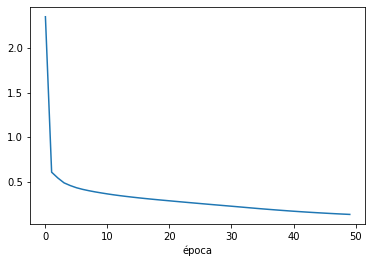

In [105]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [106]:
loss_epoch_end

[0.5739676356315613,
 0.4902600944042206,
 0.40528053045272827,
 0.3625572621822357,
 0.33306068181991577,
 0.31152594089508057,
 0.29212135076522827,
 0.27452996373176575,
 0.2589237093925476,
 0.2453676462173462,
 0.23356309533119202,
 0.22321251034736633,
 0.21420606970787048,
 0.2062845677137375,
 0.19916236400604248,
 0.19274964928627014,
 0.18694593012332916,
 0.18163436651229858,
 0.17670288681983948,
 0.17207756638526917,
 0.16768980026245117,
 0.16348180174827576,
 0.1594243198633194,
 0.15556588768959045,
 0.15192030370235443,
 0.14838916063308716,
 0.14500516653060913,
 0.1417863965034485,
 0.1386725753545761,
 0.13560903072357178,
 0.13261042535305023,
 0.1296902894973755,
 0.12683135271072388,
 0.12409193813800812,
 0.12144283205270767,
 0.11883187294006348,
 0.11627564579248428,
 0.11379501223564148,
 0.11138947308063507,
 0.10906356573104858,
 0.10676994919776917,
 0.10455039143562317,
 0.10238028317689896,
 0.10024499893188477,
 0.09814105927944183,
 0.09612743556499481

In [107]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    2.303267478942871,
    2.227701187133789,
    1.0923893451690674,
    0.5867354869842529,
    0.5144089460372925,
    0.45026642084121704,
    0.4075140357017517,
    0.37713879346847534,
    0.3534485101699829,
    0.3341451585292816,
    0.3181140422821045,
    0.30457887053489685,
    0.29283496737480164,
    0.2827608287334442,
    0.2738332152366638,
    0.2657742500305176,
    0.2583288848400116,
    0.25117507576942444,
    0.24439716339111328,
    0.23789969086647034,
    0.23167723417282104,
    0.22562651336193085,
    0.21984536945819855,
    0.2142913043498993,
    0.20894232392311096,
    0.203872948884964,
    0.19903430342674255,
    0.19439971446990967,
    0.18994088470935822,
    0.18563991785049438,
    0.18147490918636322,
    0.17744913697242737,
    0.17347246408462524,
    0.16947467625141144,
    0.16547319293022156,
    0.16150487959384918,
    0.1574639081954956,
    0.1534043848514557,
    0.14926929771900177,
    0.1452063024044037,
    0.1412365883588791,
    0.13712672889232635,
    0.1331038922071457,
    0.1291467249393463,
    0.1251506358385086,
    0.12116757035255432,
    0.11731722950935364,
    0.11364627629518509,
    0.11001908034086227,
    0.10655981302261353])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

AssertionError: ignored

# Rascunho

In [100]:
raise Exception("Execução abaixo depende de contexto apropriado")

Exception: ignored

### Execução com queda maior na loss

In [ ]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 0.9586364030838013
Epoch: 1/49 Loss: 0.565815269947052
Epoch: 2/49 Loss: 0.4770318567752838
Epoch: 3/49 Loss: 0.42453765869140625
Epoch: 4/49 Loss: 0.38708603382110596
Epoch: 5/49 Loss: 0.35843756794929504
Epoch: 6/49 Loss: 0.336288183927536
Epoch: 7/49 Loss: 0.31845659017562866
Epoch: 8/49 Loss: 0.3037392497062683
Epoch: 9/49 Loss: 0.2910858988761902
Epoch: 10/49 Loss: 0.2799944579601288
Epoch: 11/49 Loss: 0.270416259765625
Epoch: 12/49 Loss: 0.2619065046310425
Epoch: 13/49 Loss: 0.25361135601997375
Epoch: 14/49 Loss: 0.24582411348819733
Epoch: 15/49 Loss: 0.23841428756713867
Epoch: 16/49 Loss: 0.23117700219154358
Epoch: 17/49 Loss: 0.2241152971982956
Epoch: 18/49 Loss: 0.2175927609205246
Epoch: 19/49 Loss: 0.21121275424957275
Epoch: 20/49 Loss: 0.2050437331199646
Epoch: 21/49 Loss: 0.19928722083568573
Epoch: 22/49 Loss: 0.1938953399658203
Epoch: 23/49 Loss: 0.1882905215024948
Epoch: 24/49 Loss: 0.1828724443912506
Epoch: 25/49 Loss: 0.1776149421930313
Epoch: 26/49 Lo

In [ ]:
loss_epoch_end

[0.9586364030838013,
 0.565815269947052,
 0.4770318567752838,
 0.42453765869140625,
 0.38708603382110596,
 0.35843756794929504,
 0.336288183927536,
 0.31845659017562866,
 0.3037392497062683,
 0.2910858988761902,
 0.2799944579601288,
 0.270416259765625,
 0.2619065046310425,
 0.25361135601997375,
 0.24582411348819733,
 0.23841428756713867,
 0.23117700219154358,
 0.2241152971982956,
 0.2175927609205246,
 0.21121275424957275,
 0.2050437331199646,
 0.19928722083568573,
 0.1938953399658203,
 0.1882905215024948,
 0.1828724443912506,
 0.1776149421930313,
 0.17248651385307312,
 0.16733810305595398,
 0.16254152357578278,
 0.15758882462978363,
 0.1527339220046997,
 0.14789022505283356,
 0.14303667843341827,
 0.1380799561738968,
 0.13330009579658508,
 0.12855049967765808,
 0.12378916144371033,
 0.119150809943676,
 0.11474869400262833,
 0.110462486743927,
 0.10636704415082932,
 0.10245434939861298,
 0.09870947152376175,
 0.09508325904607773,
 0.09160909056663513,
 0.08813302963972092,
 0.0847537815

### Outros testes de convolução

In [108]:
in_channels_dummy = 1
out_channels_dummy = 2
kernel_size_dummy = 3
stride_dummy = 2
num_amostras_dummy = 1
x = torch.arange(30).float().reshape(num_amostras_dummy, 1, 5, 6)

In [109]:
print(x)

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.]]]])


In [110]:

conv_layer = MyConv2dForKernel( in_channels=in_channels_dummy,out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, verbose=True)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(out_channels_dummy, in_channels_dummy,  kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()
conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy
print(f"conv_layer.bias.data.shape {conv_layer.bias.data.shape}, conv_layer.bias.data {conv_layer.bias.data}")
print(f"conv_layer.weight.data.shape {conv_layer.weight.data.shape}, conv_layer.weight.data \n{conv_layer.weight.data}")

Inicializado MyConv2d
in_channels: 1 
out_channels: 2 
kernel_size: 3 
stride: 2 
weight.shape: torch.Size([2, 1, 3, 3]) 
weight: Parameter containing:
tensor([[[[-0.0056,  0.0015, -0.0048],
          [ 0.0051,  0.0006,  0.0063],
          [-0.0085,  0.0028,  0.0063]]],


        [[[-0.0088,  0.0098, -0.0020],
          [-0.0017,  0.0016, -0.0099],
          [ 0.0036, -0.0057,  0.0079]]]], requires_grad=True) 
bias.shape: torch.Size([2]) 
bias: Parameter containing:
tensor([-0.0015,  0.0052], requires_grad=True) 
conv_layer.bias.data.shape torch.Size([2]), conv_layer.bias.data tensor([0., 1.])
conv_layer.weight.data.shape torch.Size([2, 1, 3, 3]), conv_layer.weight.data 
tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]]],


        [[[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]]]])


In [111]:
print(x)

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.]]]])


In [112]:
initial_weights_dummy

tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]]],


        [[[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]]]])

In [116]:
visao_com_stride= torch.tensor([[ 0.,  2.], [12., 14.]])

In [160]:
initial_weights_dummy[:,:,0,1].squeeze()

tensor(1.)

In [117]:
torch.stack([visao_com_stride * initial_weights_dummy[:,:,0,1][i]  for i in range(2)])

tensor([[[  0.,   2.],
         [ 12.,  14.]],

        [[  0.,  20.],
         [120., 140.]]])

In [119]:
out = conv_layer(x)

 num_amostras: 1, self.out_channels: 2, num_linhas_entrada: 5, num_colunas_entrada: 6, num_linhas_saida: 2, num_colunas_saida: 2
saida.shape: torch.Size([1, 2, 2, 2])

ndx_amostra: 0

ndx_linhas_kernel, ndx_colunas_kernel: 0, 0
vou multiplicar visao_com_stride.shape: torch.Size([2, 2]) por self.weight.data[:,:,0,0].shape: torch.Size([2, 1])

visao_com_stride: tensor([[ 0.,  2.],
        [12., 14.]])

self.weight.data[:,:,ndx_linhas_kernel,ndx_colunas_kernel]: tensor([[0.],
        [9.]])

produto.shape: torch.Size([2, 2, 2]) produto: tensor([[[  0.,   0.],
         [  0.,   0.]],

        [[  0.,  18.],
         [108., 126.]]])

saida[ndx_amostra,0].shape: torch.Size([2, 2])

saida[ndx_amostra,0]: tensor([[0., 0.],
        [0., 0.]])

ndx_linhas_kernel, ndx_colunas_kernel: 0, 1
vou multiplicar visao_com_stride.shape: torch.Size([2, 2]) por self.weight.data[:,:,0,1].shape: torch.Size([2, 1])

visao_com_stride: tensor([[ 1.,  3.],
        [13., 15.]])

self.weight.data[:,:,ndx_linhas_ker

In [ ]:
visao_com_stride = torch.tensor([[0.6388, 0.0862, 0.6818, 0.7976, 0.7167, 0.1387, 0.7145, 0.9017],
        [0.5935, 0.7993, 0.5981, 0.3053, 0.3035, 0.3231, 0.6086, 0.7513],
        [0.3263, 0.3853, 0.5213, 0.1605, 0.3722, 0.5053, 0.8708, 0.0899],
        [0.8270, 0.1591, 0.0369, 0.9067, 0.0512, 0.4896, 0.7371, 0.7653],
        [0.1413, 0.5816, 0.4752, 0.0319, 0.4668, 0.6566, 0.8516, 0.3129],
        [0.6547, 0.6356, 0.0735, 0.9221, 0.4857, 0.2986, 0.5909, 0.0700],
        [0.8468, 0.0488, 0.1779, 0.6481, 0.0972, 0.9084, 0.1469, 0.7641],
        [0.0678, 0.1986, 0.5496, 0.0866, 0.5669, 0.2203, 0.0335, 0.9504]])

In [ ]:
initial_conv_weight[:,:,0,0][0,0]

tensor(-0.0041)

In [ ]:
temp = torch.tensor([[-0.0041],  [0]])

In [ ]:
temp.shape

torch.Size([2, 1])

In [ ]:
temp[1,0]

tensor(0.)

In [ ]:
temp.view(2,).shape

torch.Size([2])

In [ ]:
initial_conv_weight[:,:,0,0].view(2,)[0]

tensor(-0.0041)

In [ ]:
 [initial_conv_weight[:,:,0,0].view(2,)[i]  for i in range(2)]

[tensor(-0.0041), tensor(0.0032)]

In [ ]:
 [initial_conv_weight[:,:,0,0].view(2,)[i]  for i in range(2)]

[tensor(-0.0041), tensor(0.0032)]

In [ ]:
produto = torch.stack([visao_com_stride * initial_conv_weight[:,:,0,0][i]  for i in range(2)])

In [ ]:
produto = torch.stack([visao_com_stride * initial_conv_weight[:,:,0,0].view(2,)[i]  for i in range(2)])
produto

tensor([[[-0.0026, -0.0004, -0.0028, -0.0033, -0.0029, -0.0006, -0.0029,
          -0.0037],
         [-0.0024, -0.0033, -0.0024, -0.0012, -0.0012, -0.0013, -0.0025,
          -0.0031],
         [-0.0013, -0.0016, -0.0021, -0.0007, -0.0015, -0.0021, -0.0036,
          -0.0004],
         [-0.0034, -0.0006, -0.0002, -0.0037, -0.0002, -0.0020, -0.0030,
          -0.0031],
         [-0.0006, -0.0024, -0.0019, -0.0001, -0.0019, -0.0027, -0.0035,
          -0.0013],
         [-0.0027, -0.0026, -0.0003, -0.0038, -0.0020, -0.0012, -0.0024,
          -0.0003],
         [-0.0035, -0.0002, -0.0007, -0.0026, -0.0004, -0.0037, -0.0006,
          -0.0031],
         [-0.0003, -0.0008, -0.0022, -0.0004, -0.0023, -0.0009, -0.0001,
          -0.0039]],

        [[ 0.0020,  0.0003,  0.0022,  0.0025,  0.0023,  0.0004,  0.0023,
           0.0029],
         [ 0.0019,  0.0025,  0.0019,  0.0010,  0.0010,  0.0010,  0.0019,
           0.0024],
         [ 0.0010,  0.0012,  0.0017,  0.0005,  0.0012,  0.0016,  0.0

In [ ]:
[temp[i,0]  for i in range(2)]

[tensor(-0.0041), tensor(0.0032)]

In [ ]:
out.shape

In [ ]:
temp = torch.tensor([[[[34.]]]])

In [ ]:
temp.squeeze()

tensor(34.)

In [ ]:
temp.squeeze().shape

torch.Size([])

In [ ]:
temp.squeeze().reshape(1,)

tensor([34.])

In [ ]:
temp.view(1,-1)

tensor([[34.]])

In [ ]:
temp = torch.tensor([[[[ 46.]], [[134.]]]])

In [ ]:
temp.squeeze()

tensor([ 46., 134.])

In [ ]:
temp.squeeze().shape

torch.Size([2])

In [ ]:
temp.squeeze().reshape(2,)

tensor([ 46., 134.])

In [ ]:
temp.squeeze().shape


torch.Size([2])